# Import and misc

In [ ]:
# Instal latest torch and torchaudio
# !pip install --upgrade torch torchaudio

In [ ]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

SEED = 666

np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [ ]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [ ]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2022-11-05 12:17:48--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.126.128, 2a00:1450:4013:c01::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.126.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   240MB/s    in 5.7s    

2022-11-05 12:17:54 (250 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]

mkdir: cannot create directory ‘speech_commands’: File exists


In [ ]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [ ]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [ ]:
dataset.csv.sample(5)

,path,keyword,label
18318,speech_commands/no/2796ac50_nohash_1.wav,no,0
2865,speech_commands/eight/686d030b_nohash_0.wav,eight,0
12420,speech_commands/left/6cc28ce5_nohash_0.wav,left,0
2029,speech_commands/yes/c1d39ce8_nohash_6.wav,yes,0
16760,speech_commands/no/122c5aa7_nohash_3.wav,no,0


### Augmentations

In [ ]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [ ]:
generator = torch.Generator()
generator.manual_seed(SEED)
indexes = torch.randperm(len(dataset), generator=generator)
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [ ]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [ ]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    generator = torch.Generator()
    generator.manual_seed(SEED)
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight), generator=generator)
    return sampler

In [ ]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [ ]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [ ]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [ ]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [ ]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [ ]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [ ]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [ ]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [ ]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [ ]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt
%config InlineBackend.figure_format='retina'

history = defaultdict(list)

# Training

In [ ]:
config = TaskConfig(hidden_size=32)
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


In [ ]:
sum([p.numel() for p in model.parameters()])

25387

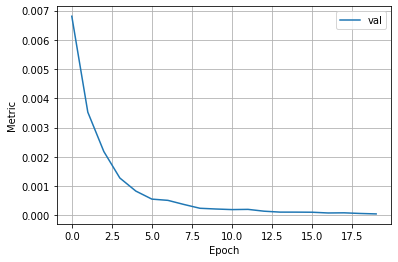

END OF EPOCH 19
Val AU-FA-FR: 4.5843452101832386e-05


In [ ]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    #au_fa_fr = validation(model, train_loader,
    #                      melspec_val, config.device)
    #history['train_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'], label='val')
    #plt.plot(history['train_metric'], label='train')
    plt.legend()
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

#print('Train AU-FA-FR: {}\nVal AU-FA-FR: {}'.format(history['train_metric'][-1], history['val_metric'][-1]))
print('Val AU-FA-FR: {}'.format(history['val_metric'][-1]))

In [ ]:
# let's save state dict of our base model
torch.save(model.state_dict(), 'base.pt')

# Streaming KWS

In [ ]:
class StreamingCRNN(nn.Module):
    def __init__(self, offline_model, max_window_length=400, step_size=1):
        super().__init__()
        self.trained_kws = offline_model.eval()

        self.melspec_win_length = 400
        self.melspec_hop_length = 160
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.trained_kws.config.sample_rate,
            n_fft=self.melspec_win_length,
            win_length=self.melspec_win_length,
            hop_length=self.melspec_hop_length,
            n_mels=self.trained_kws.config.n_mels,
            center=False
        ).to(self.trained_kws.config.device)

        assert max_window_length >= self.melspec_win_length
        assert (max_window_length - self.melspec_win_length) % self.melspec_hop_length == 0
        assert step_size <= self.melspec_hop_length

        self.stride = self.trained_kws.config.stride[1]
        self.kernel_size = self.trained_kws.config.kernel_size[1]

        self.step_size = step_size
        self.max_window_length = max_window_length
        self.added_audio = 0
        self.audio_buff = None

        self.spec_buff = None
        self.added_spec = 0
        self.spec_buff_size = self.trained_kws.config.kernel_size[1]

        self.last_gru_hidden = None
        self.gru_buff = None
        self.gru_buff_size = 16

        self.last_prob = 0.
    
    def forward(self, input):
        # add new audio frame to the audio buffer
        if self.audio_buff is None:
            self.audio_buff = input
        else:
            self.audio_buff = torch.cat((self.audio_buff, input), dim=-1)[..., -self.max_window_length:]
        
        # renew the counter to determine, whether we have added enough frames for mel spec to make a hop
        self.added_audio += self.step_size
        
        # while we have less than 400 = melspec_win_length frames in buffer
        # or while we have added less then 160 = melspec_hop_length new frames
        # - skip
        if self.audio_buff.shape[-1] < self.melspec_win_length or self.added_audio < self.melspec_hop_length:
            return self.last_prob

        # let's get new melspec column
        # as we have melspec_win_length audio frames in buffer, this will always return one column
        mel_spec_input = torch.log(
            self.melspec(self.audio_buff).clamp_(min=1e-9, max=1e9)
        )
        # renew counter of added audio frames
        self.added_audio = 0

        # now let's add new spectrogram column to the buffer
        if self.spec_buff is None:
            self.spec_buff = mel_spec_input
        else:
            self.spec_buff = torch.cat((self.spec_buff, mel_spec_input), dim=-1)[...,-self.spec_buff_size:]

        self.added_spec += 1
        # while we have less than 20 = kernel_size[1] columns in buffer
        # or while we have added less than 8 = stride[1] new columns
        # - skip
        if self.spec_buff.shape[-1] < self.kernel_size or self.added_spec < self.stride:
            return self.last_prob

        # renew counter of added spectrogram columns
        self.added_spec = 0
        
        # now we apply our network
        
        # get 1 feature column from convolution
        conv_output = self.trained_kws.conv(self.spec_buff.unsqueeze(1)).transpose(-1, -2)
        
        # run GRU for this feature column with shared hidden state
        gru_output, hidden = self.trained_kws.gru(conv_output, self.last_gru_hidden)
        self.last_gru_hidden = torch.clone(hidden)
        
        # we need a buffer for GRU outputs to make attention make sense
        if self.gru_buff is None:
            self.gru_buff = gru_output
        else:
            self.gru_buff = torch.cat((self.gru_buff, gru_output), dim=-2)[..., -self.gru_buff_size:, :]

        # attention
        contex_vector = self.trained_kws.attention(self.gru_buff)

        # classificator
        output = self.trained_kws.classifier(contex_vector)

        # let's get probability of seeing a key word
        probs = F.softmax(output, dim=-1)
        self.last_prob = float(probs.squeeze(0)[1].item())

        return self.last_prob

Let's create an audio track to test our streaming.

We will take 20 tracks from validation dataset without our keyword, and add a track with the keyword right in the middle.

In [ ]:
with_key_word = val_df[val_df.label==1].path.iloc[0]
no_key_word = val_df[val_df.label==0].path.iloc[:20].values.tolist()

no_key_word_1 = no_key_word[:10]
no_key_word_2 = no_key_word[10:]

In [ ]:
wavs = []

for path in no_key_word_1:
    wav = torchaudio.load(path)[0]
    wav = wav.sum(dim=0)
    wavs.append(wav)

wav = torchaudio.load(with_key_word)[0]
wav = wav.sum(dim=0)
wavs.append(wav)

for path in no_key_word_2:
    wav = torchaudio.load(path)[0]
    wav = wav.sum(dim=0)
    wavs.append(wav)

In [ ]:
for_streaming = torch.cat(wavs)

In [ ]:
from IPython import display

display.Audio(for_streaming, rate=16000)

In [ ]:
# key word
display.Audio(wavs[10], rate=16000)

Now we can run streaming and visualize probabilities.

In [ ]:
streaming_step_size = 1
probs = []

streaming_kws = StreamingCRNN(model, step_size=streaming_step_size).eval()
streaming_kws.cpu()


i = 0
while i * streaming_step_size < for_streaming.shape[-1]:
    chunk = for_streaming[i * streaming_step_size : (i + 1) * streaming_step_size]
    chunk = chunk.view(1, -1)
    with torch.inference_mode():
        prob = streaming_kws(chunk)
    probs.append(prob)
    i += 1

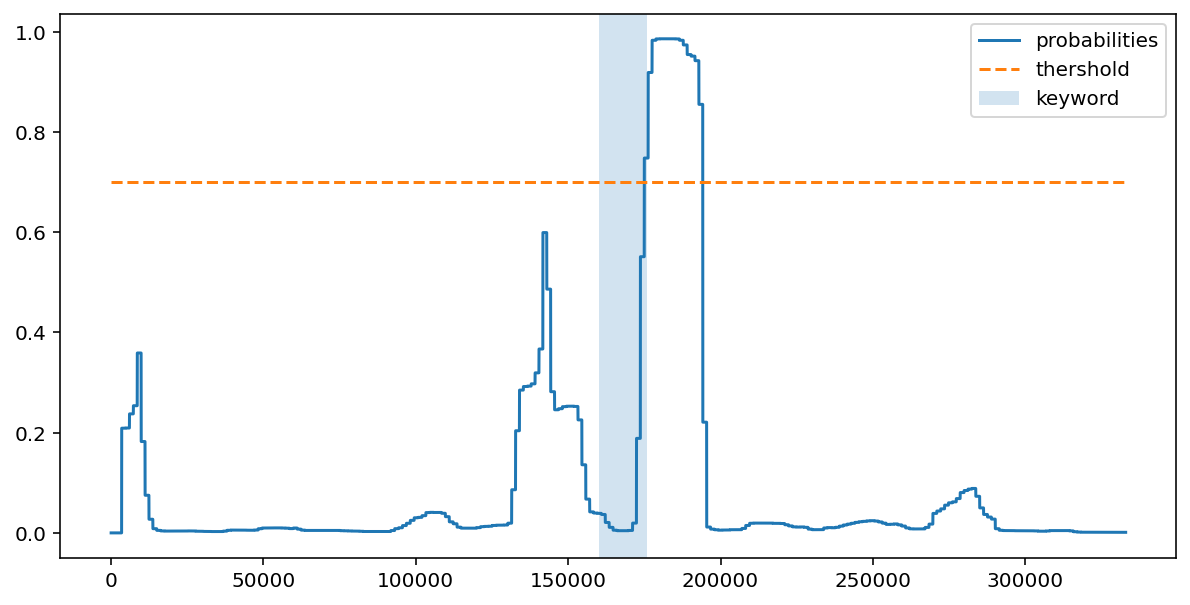

In [ ]:
plt.figure(figsize=(10, 5))
x_range = (np.arange(len(probs)) + 1) * streaming_step_size
plt.plot(x_range,probs, label='probabilities')
plt.plot([x_range[0], x_range[-1]], [0.7, 0.7], '--', label='thershold')
plt.axvspan(16000 * 10, 16000 * 11, alpha=0.2, label='keyword')
plt.legend()
plt.show()

Save streaming model in `torch.jit` format.

In [ ]:
streaming_kws_scripted = torch.jit.script(streaming_kws)
streaming_kws_scripted.save('streaming_kws.pth')

# Speed up & Compression

In [ ]:
!pip install thop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from thop import profile

In [ ]:
import tempfile

def get_size_in_megabytes(model):
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

### Dark Knowledge Distilation

First, let's try distillation with base model as teacher for a smaller version of the same model.

In [ ]:
# Define student model

student_config = TaskConfig(
    hidden_size=14,
    cnn_out_channels=2, 
    kernel_size=(11, 20), 
    stride=(7, 8), 
    gru_num_layers=1,
    num_epochs=31,
    learning_rate=1e-3
)
student = CRNN(student_config).to(student_config.device)

opt = torch.optim.Adam(
    student.parameters(),
    lr=student_config.learning_rate,
    weight_decay=student_config.weight_decay
)

sum([p.numel() for p in student.parameters()])

1789

In [ ]:
# modify training epoch to run knowledge ditillation

TEMP = 5
ALPHA = 0.1

def distil_epoch(teacher, student, opt, loader, log_melspec, device):
    student.train()
    teacher.eval()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()
        
        with torch.no_grad():
            teacher_logits = teacher(batch)
        student_logits = student(batch)

        teacher_soft_preds = F.softmax(teacher_logits / TEMP, dim=-1)
        student_soft_preds = F.softmax(student_logits / TEMP, dim=-1)
        student_hard_preds = F.softmax(student_logits, dim=-1)

        # in Knowledge Distilation paper the suggest scaling distilation loss by tempreature squared
        distil_loss = F.cross_entropy(student_soft_preds, teacher_soft_preds) * (TEMP ** 2)
        student_loss = F.cross_entropy(student_hard_preds, labels)

        loss = ALPHA * student_loss + (1 - ALPHA) * distil_loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        opt.step()

In [ ]:
distil_history = defaultdict(list)

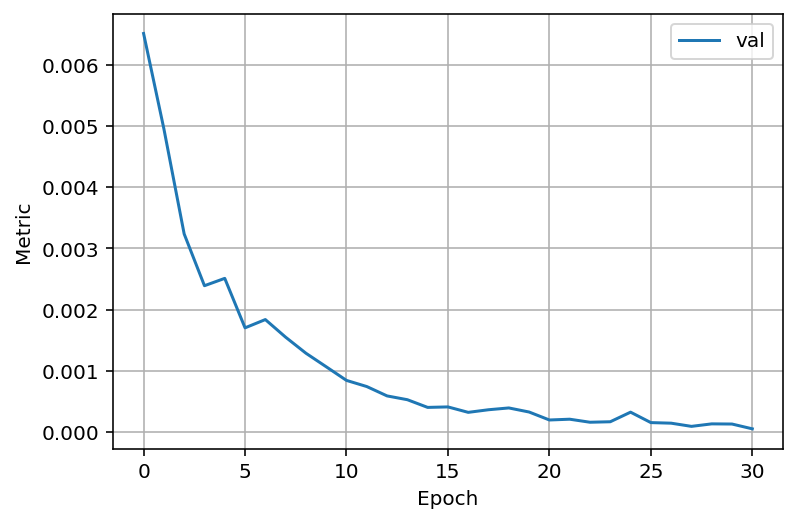

END OF EPOCH 30
Val AU-FA-FR: 5.492225340043057e-05


In [ ]:
# Run distillation

for n in range(student_config.num_epochs):

    distil_epoch(model, student, opt, train_loader, melspec_train, student_config.device)

    au_fa_fr = validation(student, val_loader, melspec_val, student_config.device)
    distil_history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(distil_history['val_metric'], label='val')
    plt.legend()
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

print('Val AU-FA-FR: {}'.format(distil_history['val_metric'][-1]))

student quality / 5e-5: 1.0984450680086113


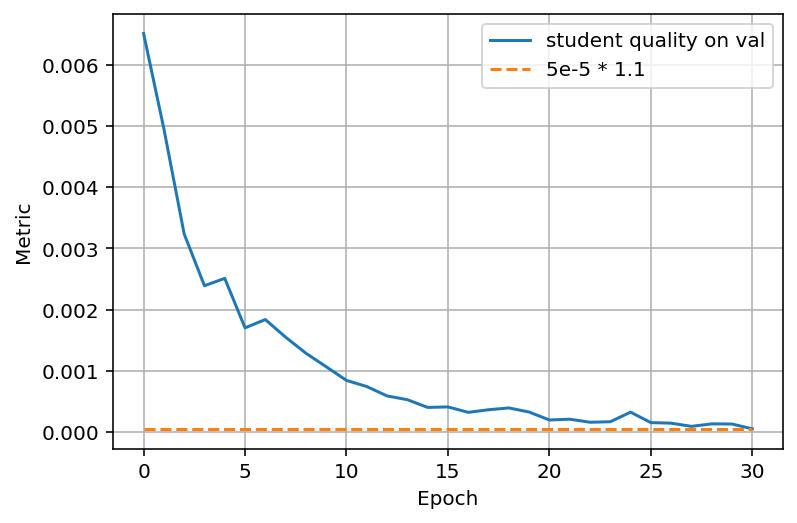

In [ ]:
print('student quality / 5e-5: {}'.format(distil_history['val_metric'][-1] / 5e-5))

plt.plot(distil_history['val_metric'], label='student quality on val')
x_range = np.arange(len(distil_history['val_metric']))
plt.plot([x_range[0], x_range[-1]], [5e-5 * 1.1, 5e-5 * 1.1], '--', label='5e-5 * 1.1')

plt.legend()
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.grid()
plt.show()

Let's save both state dict and `torch.jit` of the student model.

In [ ]:
torch.save(student.state_dict(), 'distilation_state_dict.pt')

In [ ]:
student_scripted = torch.jit.script(student)
student_scripted.save('distilation_jit.pth')

Now we should measure `compression rate` and `speed up rate`.

In [ ]:
# из канала: https://t.me/dla2022_23/21
# меряем FLOPs/MACs на 2 секундах

paths = val_df.path.iloc[:2]

wavs = [torchaudio.load(path)[0].sum(dim=0) for path in paths]
for_flops = torch.cat(wavs)

display.Audio(for_flops, rate=16000)

In [ ]:
compression_rate = get_size_in_megabytes(model) / get_size_in_megabytes(student)

speed_up_rate = profile(model, (melspec_val(for_flops.unsqueeze(0).cuda()),))[0] \
    / profile(student, (melspec_val(for_flops.unsqueeze(0).cuda()),))[0]

# после profile в выводе будет много INFO логов
clear_output()

print('compresion rate: {:.4f}'.format(compression_rate))
print('speed up rate: {:.4f}'.format(speed_up_rate))

compresion rate: 10.2823
speed up rate: 10.9215


### Quantization

Let's try Post Training Quantization. It didn't work on GPU for me, so the model has to be on CPU. But at the same time we compute MelSpectrograms on GPU, which is great. 

Let's modify validation function to meet the above requirements. 

Besides, we need to add a parameter, which will control the number of validation batches we have been applied to - we will need this later.

In [ ]:
@torch.no_grad()
def validation_ptq(model, loader, log_melspec, n_batches):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in enumerate(loader):
        if i == n_batches:
            break
        batch = log_melspec(batch.cuda()).cpu()

        output = model(batch)
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

Now let's take Post Training Quantization from the official tutorial: https://pytorch.org/tutorials/advanced/static_quantization_tutorial.html#post-training-static-quantization 

In [ ]:
import copy

num_calibration_batches = 32

# First, copy the model
model_quantized = copy.deepcopy(model).to('cpu')
model_quantized.eval()

# Here the authors fuse the model, but we din't need this.
# Fuse only works for the following combinations of modules:
# - Conv, BatchNorm
# - Conv, BatchNorm, ReLU
# - Conv, ReLU
# - Linear, BatchNorm
# - Linear, ReLU
# - BatchNorm, ReLU
# We don't have such combinations (no ReLUs and BNs in the model).
# Source: https://stackoverflow.com/a/71323509 

# Now we need to specify quantization configuration.
# I have tried a couple of them and found out, that this one works with GRU:
model_quantized.qconfig = torch.ao.quantization.default_dynamic_qconfig
# Prepare the model for calibration - we need this, 
# as we haven't done Quantization Aware Training
torch.ao.quantization.prepare(model_quantized, inplace=True)
print('Post Training Quantization Prepare: Inserting Observers')


# Calibration - apply the model to a couple of batches. No training, just eval mode
validation_ptq(model_quantized, val_loader, melspec_val, num_calibration_batches)
print('Post Training Quantization: Calibration done')

# We are done! Final step - quantize the prepared model
torch.ao.quantization.convert(
    model_quantized, 
    mapping=torch.ao.quantization.quantization_mappings.get_default_dynamic_quant_module_mappings(), 
    inplace=True
)
print('Post Training Quantization: Convert done')

Post Training Quantization Prepare: Inserting Observers
Post Training Quantization: Calibration done
Post Training Quantization: Convert done


Let's check the quality on validation dataset:

In [ ]:
validation_ptq(model_quantized, val_loader, melspec_val, len(val_loader))

3.931150925333601e-05

Amazing! Now `compression rate` and `speed up rate`:

In [ ]:
compression_rate = get_size_in_megabytes(model) / get_size_in_megabytes(model_quantized)

speed_up_rate = profile(model, (melspec_val(for_flops.unsqueeze(0).cuda()),))[0] \
    / profile(model_quantized, (melspec_val(for_flops.unsqueeze(0).cuda()).cpu(),))[0]

clear_output()

print('compresion rate: {:.4f}'.format(compression_rate))
print('speed up rate: {:.4f}'.format(speed_up_rate))

compresion rate: 2.7542
speed up rate: 2.7313


### Dark Knowledge Distilation + Quantization

Finally, let's combine the 2 approaches together. Let's quantize our student model.

In [ ]:
num_calibration_batches = 32


student_quantized = copy.deepcopy(student).to('cpu')
student_quantized.eval()

student_quantized.qconfig = torch.ao.quantization.default_dynamic_qconfig

torch.ao.quantization.prepare(student_quantized, inplace=True)
print('Post Training Quantization Prepare: Inserting Observers')


validation_ptq(student_quantized, val_loader, melspec_val, num_calibration_batches)
print('Post Training Quantization: Calibration done')

torch.ao.quantization.convert(
    student_quantized, 
    mapping=torch.ao.quantization.quantization_mappings.get_default_dynamic_quant_module_mappings(), 
    inplace=True
)
print('Post Training Quantization: Convert done')

Post Training Quantization Prepare: Inserting Observers
Post Training Quantization: Calibration done
Post Training Quantization: Convert done


In [ ]:
validation_ptq(student_quantized, val_loader, melspec_val, len(val_loader))

6.250290266955711e-05

Unfortunately, the quality got worse.

In [ ]:
compression_rate = get_size_in_megabytes(model) / get_size_in_megabytes(student_quantized)

speed_up_rate = profile(model, (melspec_val(for_flops.unsqueeze(0).cuda()),))[0] \
    / profile(student_quantized, (melspec_val(for_flops.unsqueeze(0).cuda()).cpu(),))[0]

clear_output()

print('compresion rate: {:.4f}'.format(compression_rate))
print('speed up rate: {:.4f}'.format(speed_up_rate))

compresion rate: 11.2051
speed up rate: 17.8776


But we have significantly improved `compression rate` and `speed up rate`!

### FLOPs and Memory

Let's visualize our attempts to compress and speed up the model via Metric-FLOPs and Metric-Memory.

In [ ]:
# remember, that profile return MACs = 2 * FLOPs
student_flops = profile(student, (melspec_val(for_flops.unsqueeze(0).cuda()),))[0] / 2
student_memory = get_size_in_megabytes(student)
student_metric = validation(student, val_loader, melspec_val, student_config.device)

ptq_flops = profile(model_quantized, (melspec_val(for_flops.unsqueeze(0).cuda()).cpu(),))[0] / 2
ptq_memory = get_size_in_megabytes(model_quantized)
ptq_metric = validation_ptq(model_quantized, val_loader, melspec_val, len(val_loader))

student_ptq_flops = profile(student_quantized, (melspec_val(for_flops.unsqueeze(0).cuda()).cpu(),))[0] / 2
student_ptq_memory = get_size_in_megabytes(student_quantized)
student_ptq_metric = validation_ptq(student_quantized, val_loader, melspec_val, len(val_loader))

clear_output()

In [ ]:
# As in this paper: https://arxiv.org/pdf/1905.11946.pdf 
# let's sort FLOPs and memory in ascending order and visualize them on x-axis

flops = np.array([student_flops, ptq_flops, student_ptq_flops])
memory = np.array([student_memory, ptq_memory, student_ptq_memory])
metrics = np.array([student_metric, ptq_metric, student_ptq_metric])

indxs_flops = np.argsort(flops)
indxs_memory = np.argsort(memory)

names = ['Dark Knowledge Distillation', 'Quantization', 'Dark Knowledge Distillation + Quantization']

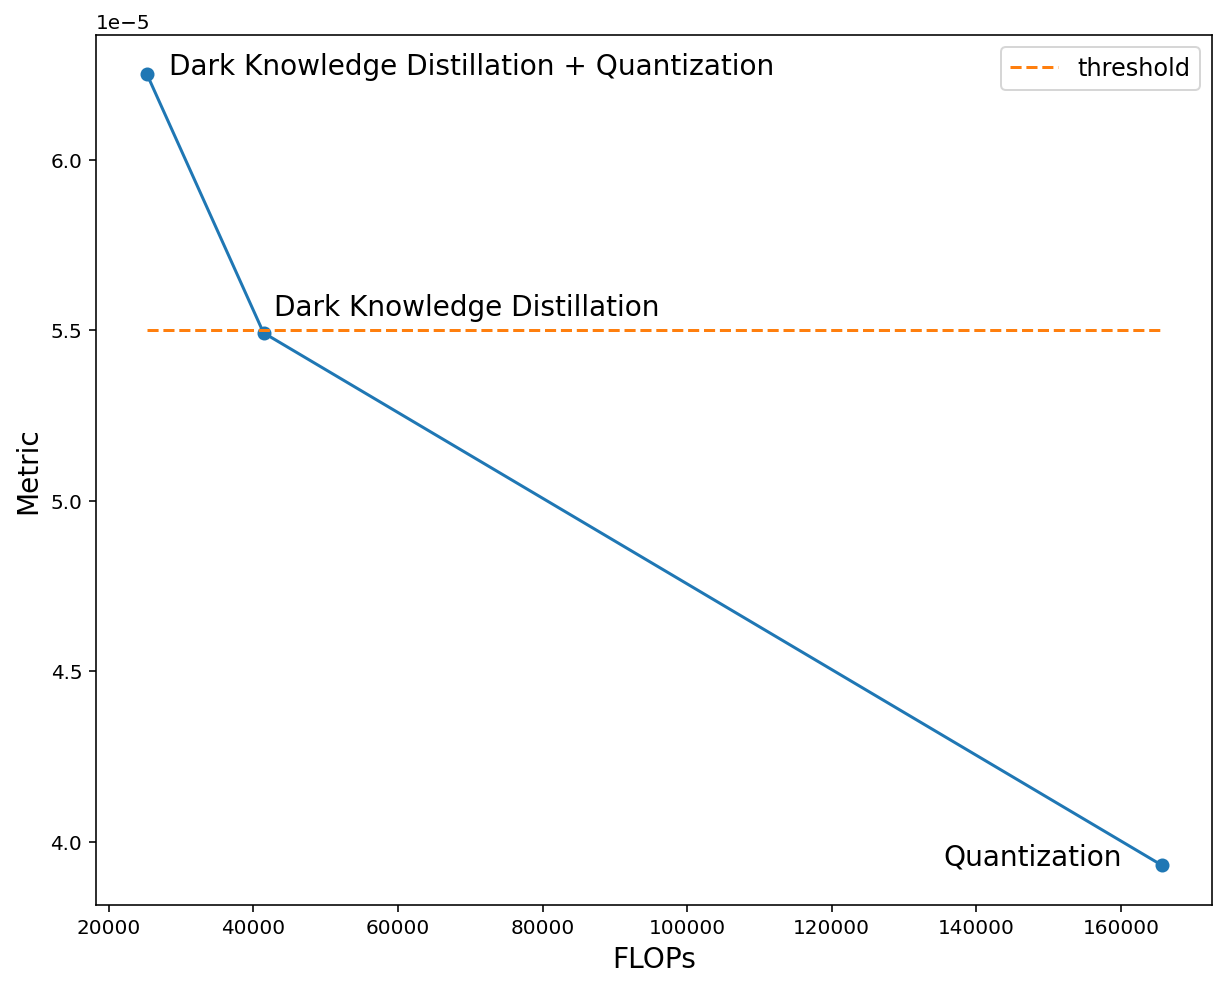

In [ ]:
plt.figure(figsize=(10, 8))

flops_sorted = np.sort(flops)
plt.plot(flops_sorted, metrics[indxs_flops])

plt.text(flops_sorted[0] + 3e3, metrics[indxs_flops[0]], names[indxs_flops[0]], fontsize=14)
plt.text(flops_sorted[1] + 1.5e3, metrics[indxs_flops[1]] + 5e-7, names[indxs_flops[1]], fontsize=14)
plt.text(flops_sorted[2] - 5.5e3, metrics[indxs_flops[2]], names[indxs_flops[2]], fontsize=14, horizontalalignment='right')

plt.scatter(flops_sorted, metrics[indxs_flops])

plt.plot([flops_sorted[0], flops_sorted[-1]], [5e-5 * 1.1, 5e-5 * 1.1], '--', label='threshold')

plt.xlabel('FLOPs', fontsize=14)
plt.ylabel('Metric', fontsize=14)
plt.legend(fontsize=12)
plt.show()

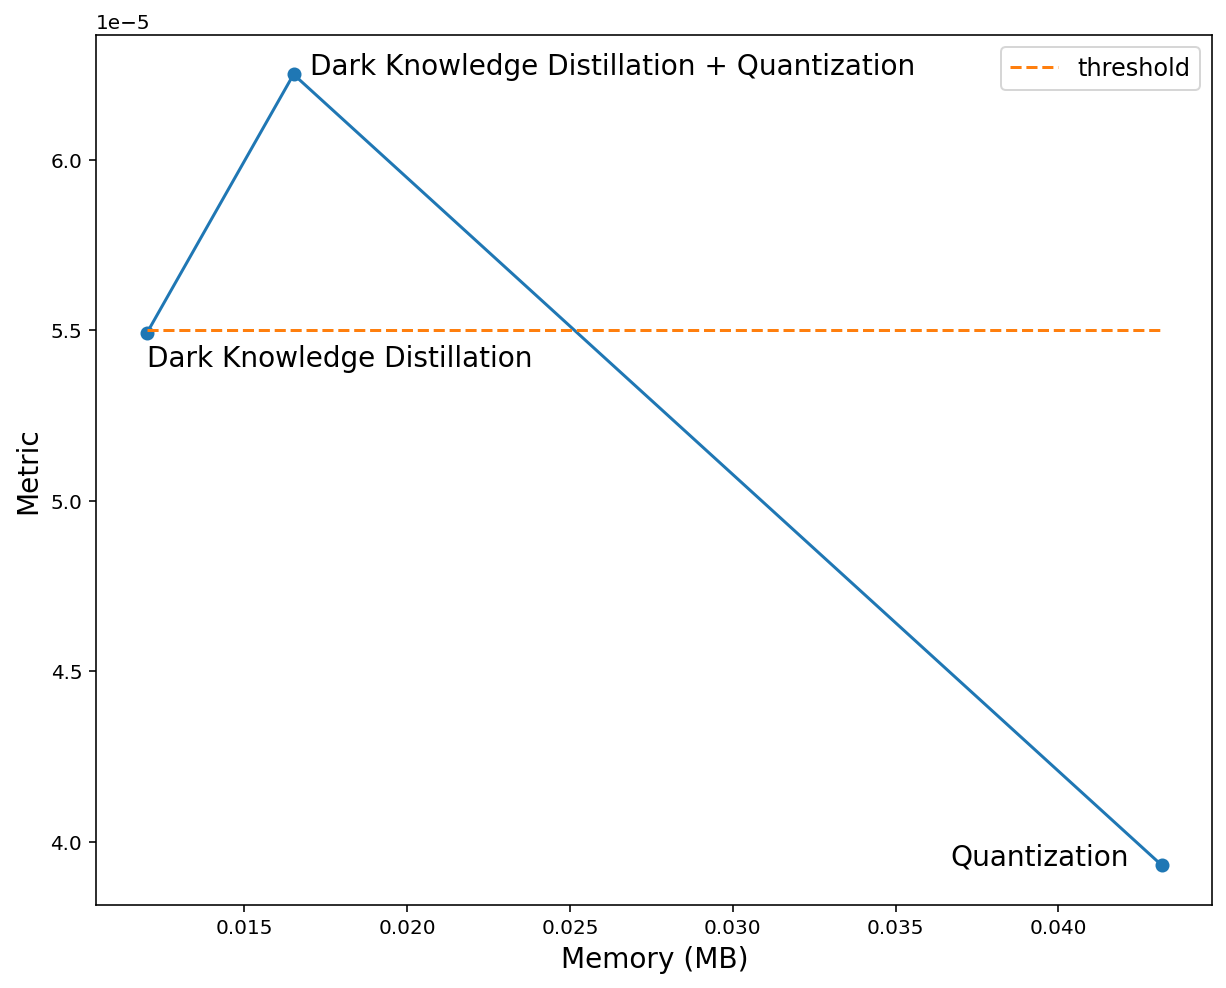

In [ ]:
plt.figure(figsize=(10, 8))

mem_sorted = np.sort(memory)
plt.plot(mem_sorted, metrics[indxs_memory])

plt.text(mem_sorted[0], metrics[indxs_memory[0]] - 1e-6, names[indxs_memory[0]], fontsize=14)
plt.text(mem_sorted[1] + 5e-4, metrics[indxs_memory[1]], names[indxs_memory[1]], fontsize=14)
plt.text(mem_sorted[2] - 1e-3, metrics[indxs_memory[2]], names[indxs_memory[2]], fontsize=14, horizontalalignment='right')

plt.scatter(mem_sorted, metrics[indxs_memory])

plt.plot([mem_sorted[0], mem_sorted[-1]], [5e-5 * 1.1, 5e-5 * 1.1], '--', label='threshold')

plt.xlabel('Memory (MB)', fontsize=14)
plt.ylabel('Metric', fontsize=14)
plt.legend(fontsize=12)
plt.show()